In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [43]:
# Import the excel spreadsheets in the data folder
installer_df = pd.read_excel('../data/Installer.xlsx')
involver_df = pd.read_excel('../data/Involver.xlsx')

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [44]:
# Attempt to merge using a subset of key columns
merge_on_columns = ['Site', 'Vessel_Name', 'Wo_No']

df = pd.concat([installer_df, involver_df], axis=0)

# feature_columns = ['Object', 'Group', 'Symptom', 'Error_Cause', 'Cause_Details', 'Error_Class', 'Discovery', 'Completion_Note', 'Action_Taken', 'Work_Description', 'Directive']
feature_columns = ['Object', 'Group', 'Object_Type','Completion_Note', 'Work_Description', 'Directive']
# TODO: Change this to ESB1
target_column = 'EBS1'

# Filter the dataframe for the selected columns
df = df[feature_columns + [target_column]].dropna()

In [45]:
# Convert the target column to ids 
# Encode the target column
label_encoder = LabelEncoder()
df[target_column] = label_encoder.fit_transform(df[target_column].astype(str))
df[target_column].dtype, df[target_column].unique()

(dtype('int64'),
 array([24,  2, 13,  5, 25, 12, 10,  4, 20,  8, 21, 28, 29,  9, 15, 17,  1,
         3, 18, 19, 26, 11,  0,  7, 22, 23, 14,  6, 27, 16]))

In [46]:
# Define the TF-IDF vectorizer for text columns
preprocessor = ColumnTransformer(
    transformers=[
        (col, TfidfVectorizer(), col) for col in feature_columns
    ], remainder='drop'
)

# Create a pipeline with preprocessor and scaler
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler())
])

# Split the data into training and testing sets
X = df[feature_columns]
y = df[target_column]

# Check if the length of X and y are consistent
assert len(X) == len(y), "Mismatch in the number of samples between X and y"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the training data
X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

# Apply RandomOverSampler to the preprocessed training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_preprocessed, y_train)

# Create a pipeline with the resampled data and MLPClassifier
final_pipeline = Pipeline([
    ('classifier', MLPClassifier(random_state=42, verbose=True))
])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__hidden_layer_sizes': [(50, 50), (100,), (100, 50), (100, 100)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
    'classifier__max_iter': [200, 500]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(final_pipeline, param_grid, n_jobs=-1, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV with resampled data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Iteration 1, loss = 1.90601809
Iteration 2, loss = 0.39601703
Iteration 3, loss = 0.11075264
Iteration 4, loss = 0.05201898
Iteration 5, loss = 0.03275432
Iteration 6, loss = 0.02327637
Iteration 7, loss = 0.01801417
Iteration 8, loss = 0.01433046
Iteration 9, loss = 0.01181247
Iteration 10, loss = 0.00988068
Iteration 11, loss = 0.00845681
Iteration 12, loss = 0.00731193
Iteration 13, loss = 0.00637981
Iteration 14, loss = 0.00565465
Iteration 15, loss = 0.00503296
Iteration 16, loss = 0.00451223
Iteration 17, loss = 0.00408856
Iteration 18, loss = 0.00371137
Iteration 19, loss = 0.00339957
Iteration 20, loss = 0.00310428
Iteration 21, loss = 0.00286454
Iteration 22, loss = 0.00266028
Iteration 23, loss = 0.00246970
Iteration 24, loss = 0.00229624
Iteration 25, loss = 0.00215441
Iteration 26, loss = 0.00201634
Iteration 27, loss = 0.00189693
Iteration 28, loss = 0.00178643
Iteration 29, loss = 0.00168795
Iteration 30, loss = 0.00160016
Iteration 31, loss = 0.00151718
Iteration 32, los

Test accuracy:  0.8442622950819673
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00        25
           3       0.00      0.00      0.00         1
           4       0.75      1.00      0.86         3
           5       0.74      1.00      0.85        25
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         2
           9       1.00      0.33      0.50         3
          10       1.00      0.67      0.80         3
          12       0.67      1.00      0.80         2
          13       1.00      0.93      0.96        29
          14       1.00      1.00      1.00         1
          16       0.00      0.00      0.00         1
          17       1.00      0.20      0.33         5
          20       0.33      1.00      0.50         1
          21       1.00

c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\syeda\OneDrive\Documents\American Bureau of Shipping\projects\nlp_risk_prediction\nlp_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set

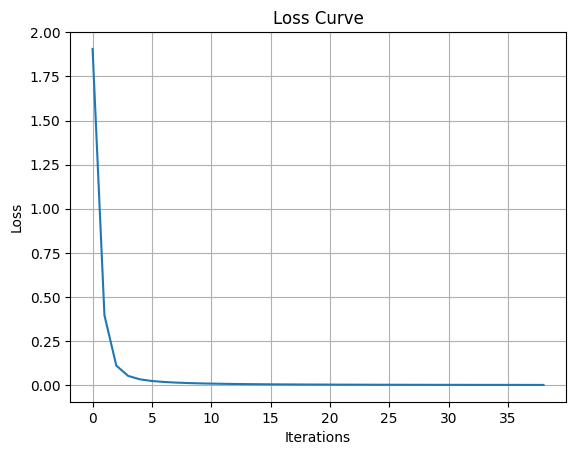

In [49]:
X_test_preprocessed = pipeline.transform(X_test)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_preprocessed)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
classifier = best_model.named_steps['classifier']
plt.plot(classifier.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()